The beginning of my senior thesis work, trying to run phase-extracted data from Will through NF2FF

In [1]:
## import statements:
import numpy as np
from matplotlib.pyplot import *
from numpy.fft import fft2
from numpy.fft import ifft2
from numpy.fft import fftshift
from numpy.fft import ifftshift
from scipy.interpolate import griddata


import pandas
from matplotlib.colors import LogNorm

from scipy.interpolate import RectBivariateSpline

import NF2FF as nf

import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

ModuleNotFoundError: No module named 'pykrige'

In [57]:
dat=np.load("/Users/ana/Documents/Yale/Newburgh Lab Research/Python_NF2FF/NF_data/f354cplxEfield.npz")
for key in dat.keys():
    print(key)
NF_EW_Complex=dat['cplxEfieldEW']
NF_NS_Complex=dat['cplxEfieldNS']

print(NF_EW_Complex.shape)
print(NF_NS_Complex.shape)

cplxEfieldEW
cplxEfieldNS
(86, 86)
(86, 86)


Can't use the RegularGridding function for this because of how the data is, so will make the gridding myself in the next cell(s)

In [58]:
# making the gridding

M=NF_EW_Complex.shape[0]
N=NF_EW_Complex.shape[1]
dx = 0.33
dy = 0.33
dtheta = 0.05
dphi = 0.05

# setting up k-space, theta, phi grids
# See equations (16-13a) and (16-13b) in Balanis
# Zero padding is used to increase the resolution of the plane wave spectral domain.
MI=4*M;#2^(ceil(log2(M))+1);
NI=4*N;#2^(ceil(log2(N))+1);
m=np.linspace(-MI/2,MI/2-1,MI);
n=np.linspace(-NI/2,NI/2-1,NI)
k_X_Rectangular=(2*np.pi*m)/(MI*dx);
k_Y_Rectangular=(2*np.pi*n)/(NI*dy);
theta=np.arange(-np.pi/2+dtheta,np.pi/2-dtheta,dtheta);
phi=np.arange(0+dphi,np.pi-dphi,dphi);
[theta,phi]=np.meshgrid(theta,phi);

In [59]:
# frequency stuff
k0 = nf.Calculate_k0(661*(10**6))
nyquist_m = nf.NyquistSampling(661*(10**6))

print(nyquist_m)

0.22677190468986383


<ipython-input-60-4ef377d27ab1>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0][0].pcolormesh(x,y,np.abs(NF_EW_Complex))
<ipython-input-60-4ef377d27ab1>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0][1].pcolormesh(x,y,np.abs(NF_NS_Complex))
<ipython-input-60-4ef377d27ab1>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X 

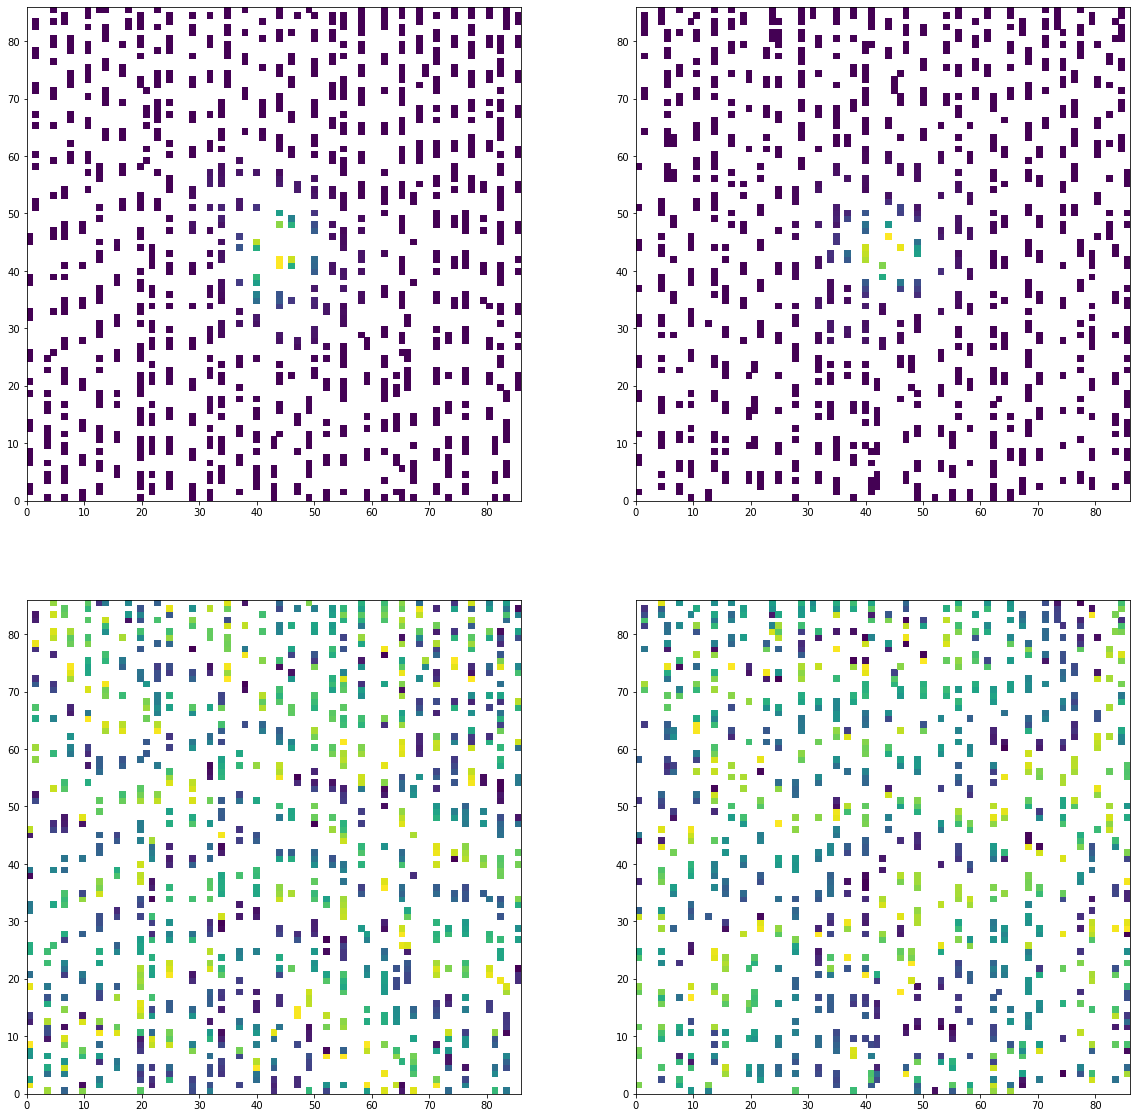

In [60]:
# [x_grid,y_grid]=np.meshgrid(x,y)

x=np.linspace(0,86,86)
y=np.linspace(0,86,86)
[x_grid,y_grid]=np.meshgrid(x,y)

fig,ax=subplots(2,2,figsize=(20,20))
ax[0][0].pcolormesh(x,y,np.abs(NF_EW_Complex))
ax[0][1].pcolormesh(x,y,np.abs(NF_NS_Complex))
ax[1][0].pcolormesh(x,y,np.angle(NF_EW_Complex))
ax[1][1].pcolormesh(x,y,np.angle(NF_NS_Complex))
for axis_set in ax:
    for a in axis_set:
        a.set_aspect('equal')

<ipython-input-61-a4db26f1560e>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0][0].pcolormesh(x,y,(NF_EW_Complex.real))
<ipython-input-61-a4db26f1560e>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0][1].pcolormesh(x,y,(NF_NS_Complex.imag))
<ipython-input-61-a4db26f1560e>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and

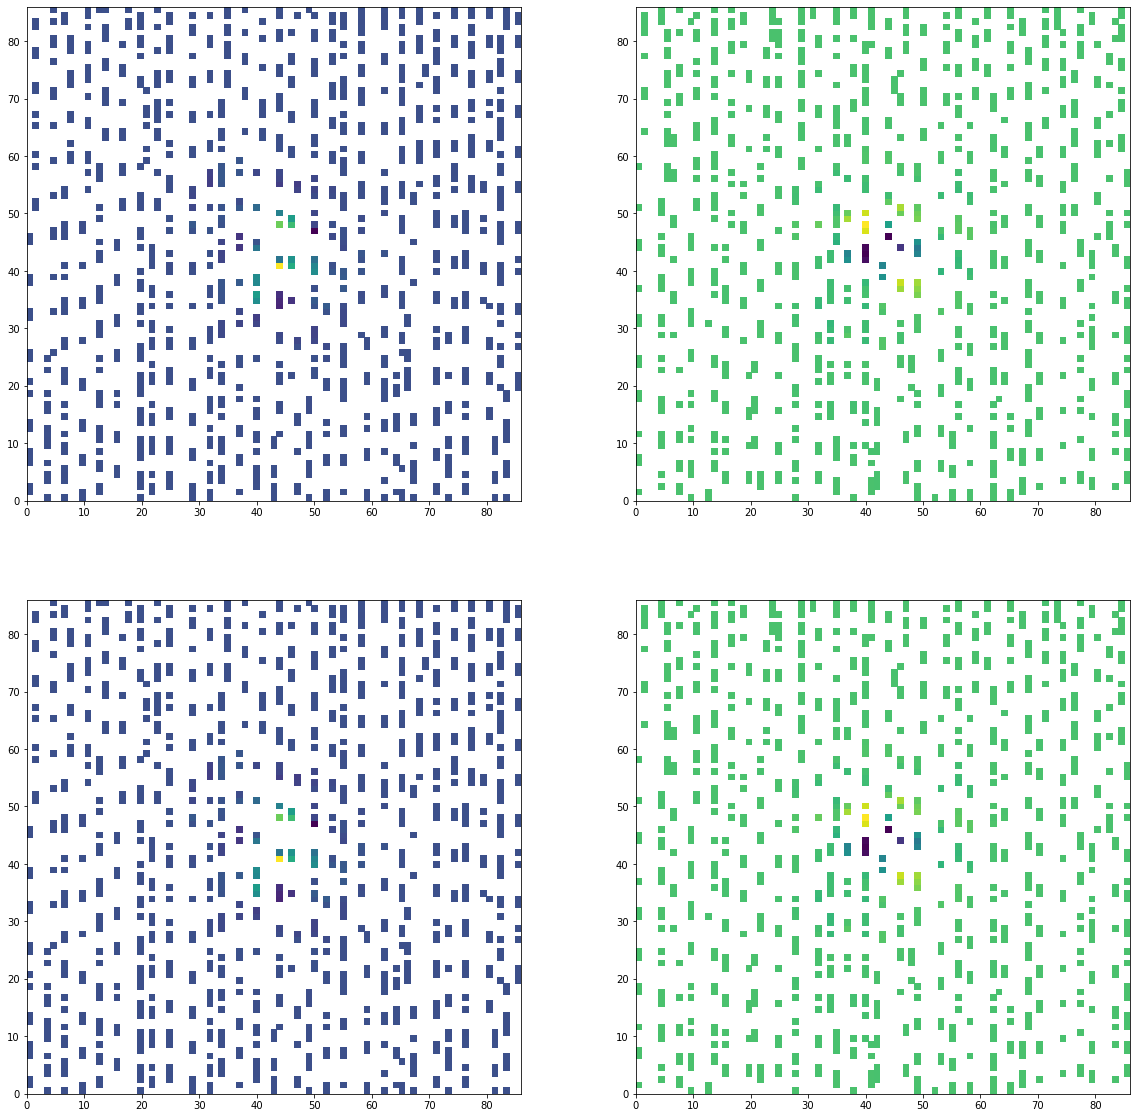

In [61]:
fig,ax=subplots(2,2,figsize=(20,20))
ax[0][0].pcolormesh(x,y,(NF_EW_Complex.real))
ax[0][1].pcolormesh(x,y,(NF_NS_Complex.imag))
ax[1][0].pcolormesh(x,y,(NF_EW_Complex.real))
ax[1][1].pcolormesh(x,y,(NF_NS_Complex.imag))
for axis_set in ax:
    for a in axis_set:
        a.set_aspect('equal')

In [62]:
# looks like a lot of NaNs--checking how many

print(np.count_nonzero(np.isnan(NF_EW_Complex)))
print(NF_EW_Complex.shape)
print(6356/86/86)

6356
(86, 86)
0.8593834505137913


There are a lot of NaNs and I don't know if NF2FF will like that. I'll just go ahead with it and see what happens I guess?

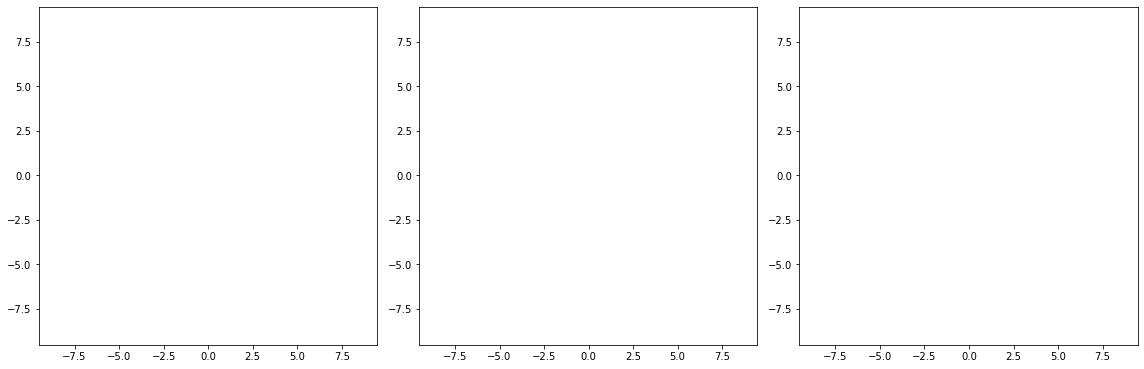

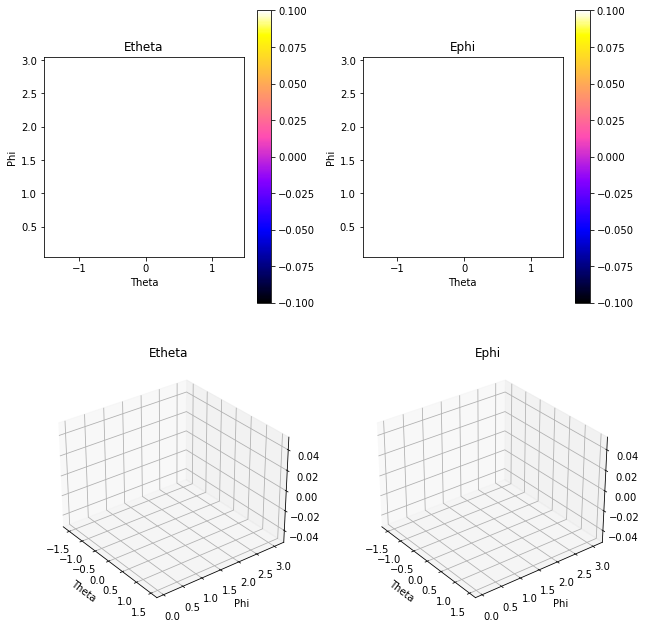

In [63]:
FourierSpace=nf.NFtoFourier(NF_EW_Complex,NF_NS_Complex,k_X_Rectangular,k_Y_Rectangular,k0,plotFourier=True)
[Etheta,Ephi]=nf.FouriertoFF(FourierSpace[0],FourierSpace[1],FourierSpace[2],theta,phi,k_X_Rectangular,k_Y_Rectangular,k0,FFOutputs=True)

In [64]:
print(FourierSpace[0])

[[nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 ...
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]]


## Trying some interpolation

My idea: make a generic x, y grid (as I did for the plotting above), use np.isnan to select for data points with no nan. Use these as the starting point for interpolation and interpolate to the full x, y grid

In [65]:
# making grids
x=np.linspace(0,86,86)
y=np.linspace(0,86,86)
[x_grid,y_grid]=np.meshgrid(x,y)

In [66]:
# finding and selecting data points with no nans
EW_nan_boolean = np.isnan(NF_EW_Complex)
EW_notnan_boolean = np.invert(EW_nan_boolean)
NS_nan_boolean = np.isnan(NF_NS_Complex)
NS_notnan_boolean = np.invert(NS_nan_boolean)

# NF_EW_Complex_flat = NF_EW_Complex.flatten()
# x_grid_flat = x_grid.flatten()
NF_EW_Complex_selected = NF_EW_Complex[EW_notnan_boolean]
x_EW_grid_selected = x_grid[EW_notnan_boolean]
y_EW_grid_selected = y_grid[EW_notnan_boolean]

NF_NS_Complex_selected = NF_NS_Complex[NS_notnan_boolean]
x_NS_grid_selected = x_grid[NS_notnan_boolean]
y_NS_grid_selected = y_grid[NS_notnan_boolean]

In [67]:
print(NF_EW_Complex_selected.shape)
print(x_EW_grid_selected.shape)
print(y_EW_grid_selected.shape)

print(EW_nan_boolean.shape)
print(np.count_nonzero(EW_nan_boolean))
print(86*86-np.count_nonzero(NS_nan_boolean))
print(np.count_nonzero(NS_notnan_boolean))
print(NF_NS_Complex_selected.shape)
print(x_NS_grid_selected.shape)

(1040,)
(1040,)
(1040,)
(86, 86)
6356
947
947
(947,)
(947,)


In [68]:
scatter(x_EW_grid_selected,y_EW_
        grid_selected,c=np.abs(NF_EW_Complex_selected))

SyntaxError: invalid syntax (<ipython-input-68-526efed29de8>, line 2)

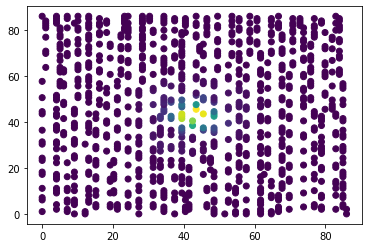

In [69]:
scatter(x_NS_grid_selected,y_NS_grid_selected,c=np.abs(NF_NS_Complex_selected))

In [70]:
# performing the interpolation--real and imaginary separately
NF_EW_real_selected = NF_EW_Complex_selected.real
NF_EW_im_selected = NF_EW_Complex_selected.imag
NF_NS_real_selected = NF_NS_Complex_selected.real
NF_NS_im_selected = NF_NS_Complex_selected.imag

NF_EW_real_interp = griddata((x_EW_grid_selected,y_EW_grid_selected),NF_EW_real_selected,(x_grid,y_grid),fill_value=0)
NF_NS_real_interp = griddata((x_NS_grid_selected,y_NS_grid_selected),NF_NS_real_selected,(x_grid,y_grid),fill_value=0)
NF_EW_im_interp = griddata((x_EW_grid_selected,y_EW_grid_selected),NF_EW_im_selected,(x_grid,y_grid),fill_value=0)
NF_NS_im_interp = griddata((x_NS_grid_selected,y_NS_grid_selected),NF_NS_im_selected,(x_grid,y_grid),fill_value=0)

In [71]:
# trying Krige interpolation

NF_EW_Krige_real = OrdinaryKriging
                            beam_OK_real = OrdinaryKriging(x_noNan,y_noNan,V_LC_selected_real,variogram_model=variogram_model)
                            Krig_Interp_real,self.real_interp_variance = beam_OK_real.execute("grid",x_interp,y_interp)

                            if complex_beam:

                                beam_OK_im = OrdinaryKriging(x_noNan,y_noNan,V_LC_selected_im,variogram_model=variogram_model)
                                Krig_Interp_im,self.im_interp_variance = beam_OK_im.execute("grid",x_interp,y_interp)

                                self.Krig_Interp[:,:,f_index,chanind] = Krig_Interp_real + 1j*Krig_Interp_im
                                self.Krig_Interp_amp[:,:,f_index,chanind] = np.abs(self.Krig_Interp[:,:,f_index,chanind])
                                self.Krig_Interp_phase[:,:,f_index,chanind] = np.angle(self.Krig_Interp[:,:,f_index,chanind])
                                self.Krig_Interp_phase_unwrapped[:,:,f_index,chanind] = np.unwrap(self.Krig_Interp_phase)

                            else:
                                self.Krig_Interp[:,:,f_index,chanind] = Krig_Interp_real

In [72]:
# putting interpolated data together into complex arrays
NF_EW_interped = NF_EW_real_interp + 1j*NF_EW_im_interp
NF_NS_interped = NF_NS_real_interp + 1j*NF_NS_im_interp

<ipython-input-75-1dbc79e113ca>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = ax[0][0].pcolormesh(x_grid,y_grid,NF_EW_real_interp)
<ipython-input-75-1dbc79e113ca>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = ax[0][1].pcolormesh(x_grid,y_grid,NF_NS_real_interp)
<ipython-input-75-1dbc79e113ca>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the

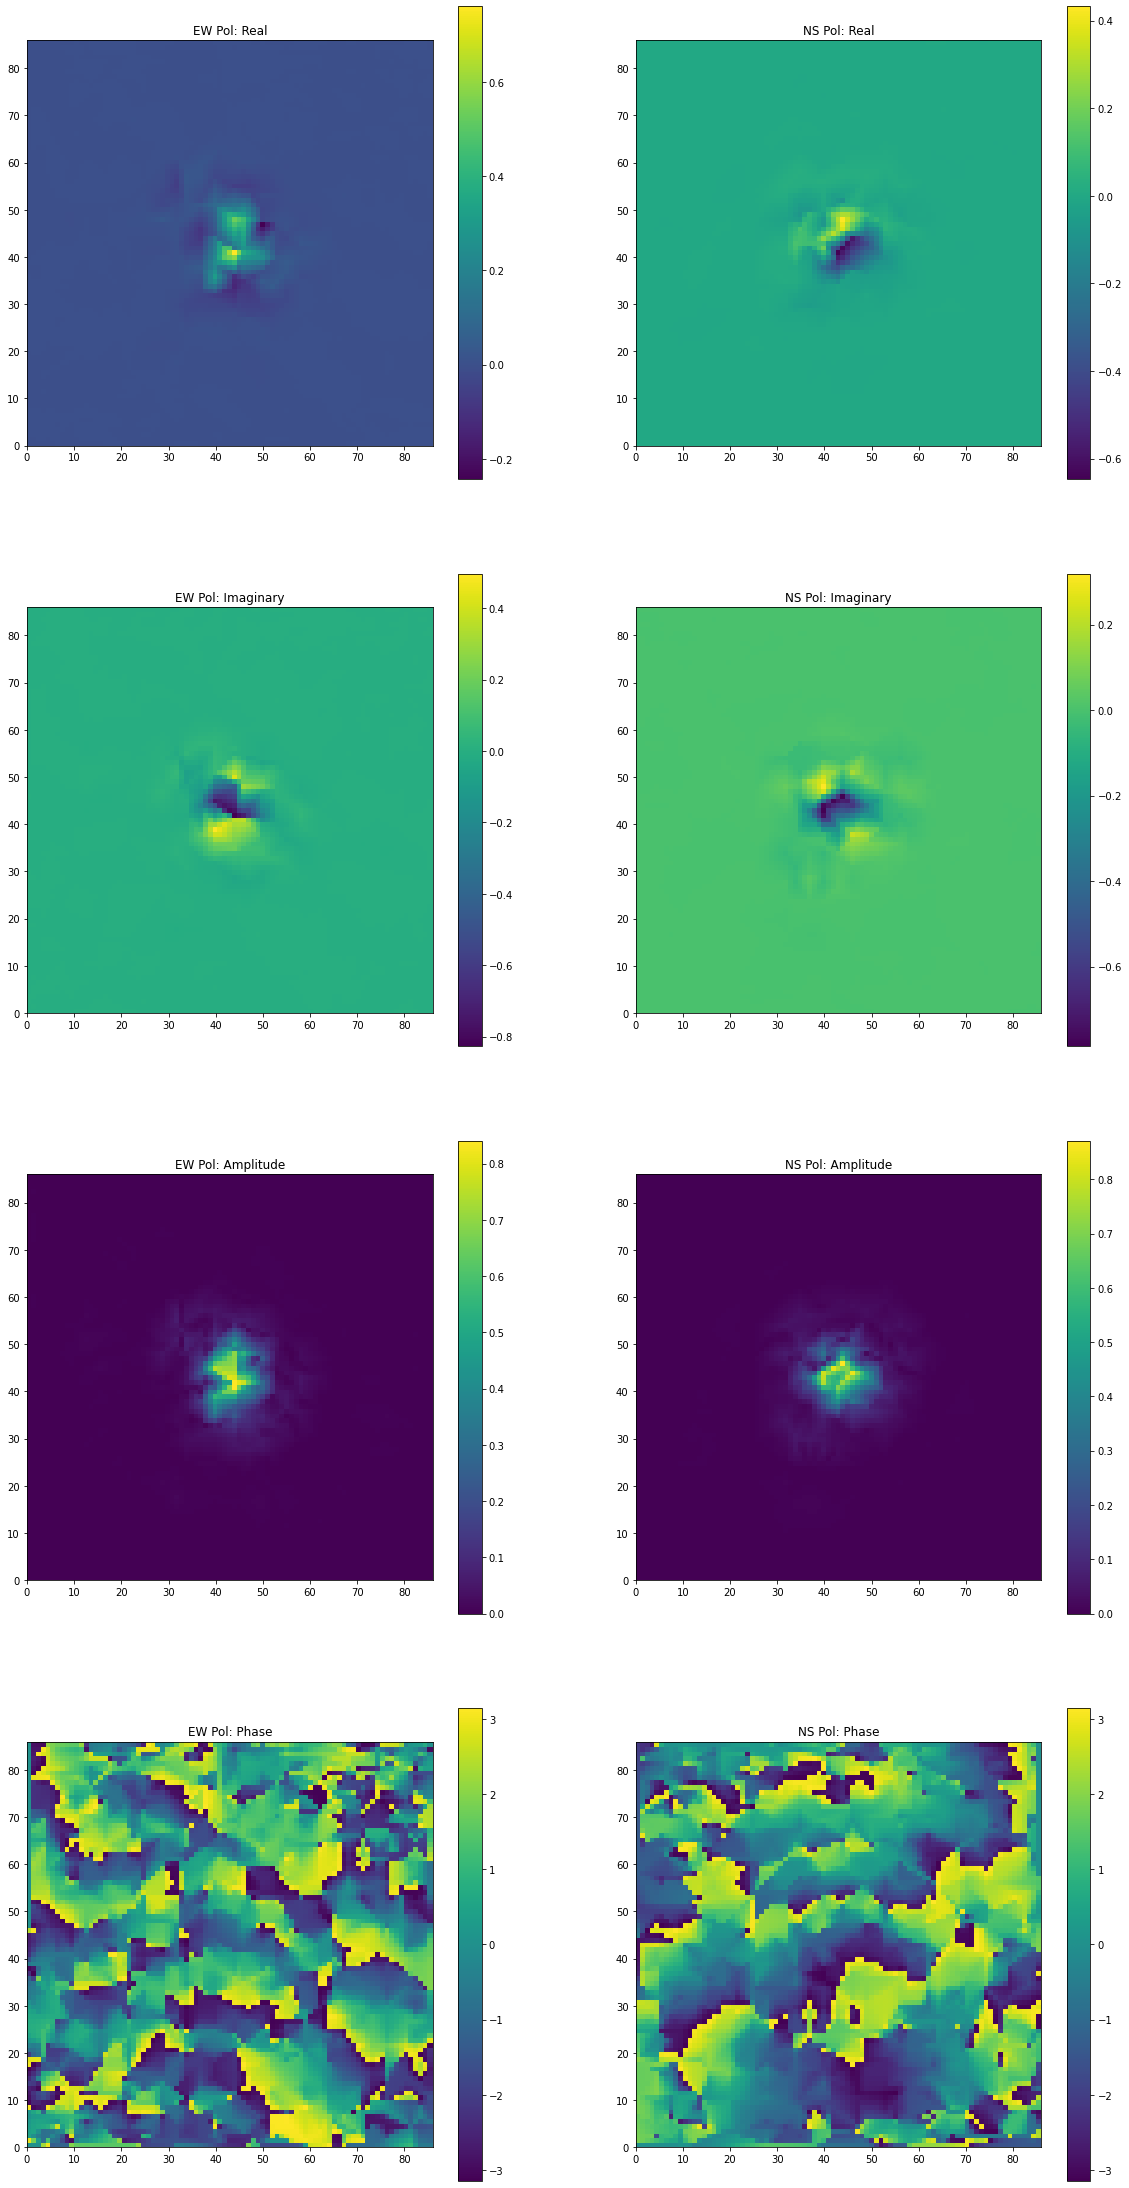

In [75]:
fig,ax=subplots(4,2,figsize=(20,40))
pcm = ax[0][0].pcolormesh(x_grid,y_grid,NF_EW_real_interp)
ax[0][0].set_title('EW Pol: Real')
colorbar(mappable=pcm,ax=ax[0][0])
pcm = ax[0][1].pcolormesh(x_grid,y_grid,NF_NS_real_interp)
ax[0][1].set_title('NS Pol: Real')
colorbar(mappable=pcm,ax=ax[0][1])
pcm = ax[1][0].pcolormesh(x_grid,y_grid,NF_EW_im_interp)
ax[1][0].set_title('EW Pol: Imaginary')
colorbar(mappable=pcm,ax=ax[1][0])
pcm = ax[1][1].pcolormesh(x_grid,y_grid,NF_NS_im_interp)
ax[1][1].set_title('NS Pol: Imaginary')
colorbar(mappable=pcm,ax=ax[1][1])
pcm = ax[2][0].pcolormesh(x_grid,y_grid,np.abs(NF_EW_interped))
ax[2][0].set_title('EW Pol: Amplitude')
colorbar(mappable=pcm,ax=ax[2][0])
pcm = ax[2][1].pcolormesh(x_grid,y_grid,np.abs(NF_NS_interped))
ax[2][1].set_title('NS Pol: Amplitude')
colorbar(mappable=pcm,ax=ax[2][1])
pcm = ax[3][0].pcolormesh(x_grid,y_grid,np.angle(NF_EW_interped))
ax[3][0].set_title('EW Pol: Phase')
colorbar(mappable=pcm,ax=ax[3][0])
pcm = ax[3][1].pcolormesh(x_grid,y_grid,np.angle(NF_NS_interped))
ax[3][1].set_title('NS Pol: Phase')
colorbar(mappable=pcm,ax=ax[3][1])
for axis_set in ax:
    for a in axis_set:
        a.set_aspect('equal')

[array([[ 1.39330255e-06+9.39728808e-07j,  4.10511369e-07+1.83964881e-06j,
        -1.08188388e-06+1.76979705e-06j, ...,
        -8.88263295e-08-1.23034495e-06j,  8.45339092e-07-1.06250911e-06j,
         1.48269489e-06-2.31108962e-07j],
       [ 3.90734111e-08+1.38013759e-06j, -1.02800658e-06+1.21685224e-06j,
        -1.78190549e-06+2.11222969e-07j, ...,
         8.36252145e-07-4.96181008e-07j,  1.05909652e-06+1.56326819e-07j,
         8.04753939e-07+8.91753933e-07j],
       [-9.93380715e-07+5.99240608e-07j, -1.33793330e-06-1.81659166e-07j,
        -1.01373805e-06-1.15151303e-06j, ...,
         6.38121429e-07+5.76335771e-07j,  2.04532423e-07+8.88338210e-07j,
        -3.82373759e-07+9.32460152e-07j],
       ...,
       [-9.51648244e-07-2.31509521e-06j,  9.99414512e-07-2.44296265e-06j,
         2.52391403e-06-1.10770856e-06j, ...,
        -5.99029201e-07+1.92629868e-06j, -1.99536944e-06+9.18317414e-07j,
        -2.18262900e-06-8.86087496e-07j],
       [ 9.71840442e-07-2.05758357e-06j,  2

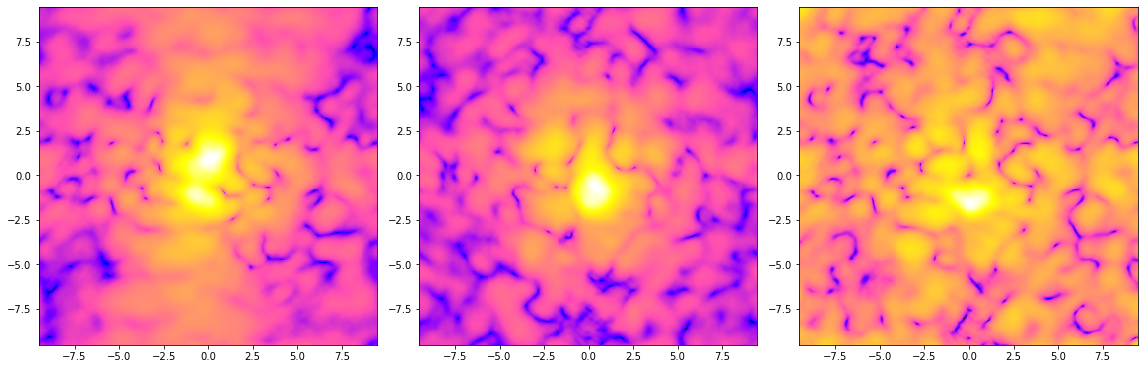

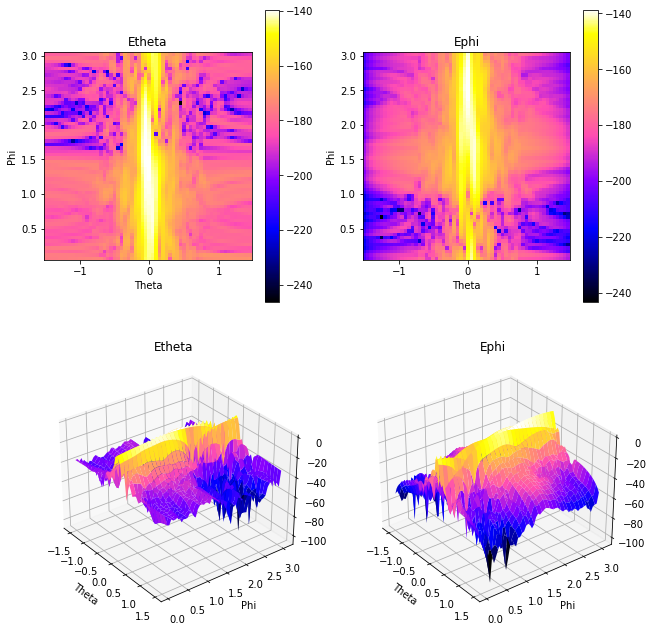

In [76]:
FourierSpace=nf.NFtoFourier(NF_EW_interped,NF_NS_interped,k_X_Rectangular,k_Y_Rectangular,k0,plotFourier=True)
print(FourierSpace)

[Etheta,Ephi]=nf.FouriertoFF(FourierSpace[0],FourierSpace[1],FourierSpace[2],theta,phi,k_X_Rectangular,k_Y_Rectangular,k0,FFOutputs=True)

In [77]:
print(np.count_nonzero(np.isnan(NF_EW_interped)))
print(np.count_nonzero(np.isnan(NF_NS_interped)))

0
0


<ipython-input-78-770899a125f2>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = pcolormesh(theta,phi,20*np.log10(np.abs(Etheta)),cmap='gnuplot2')
<ipython-input-78-770899a125f2>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = pcolormesh(theta,phi,20*np.log10(np.abs(Ephi)),cmap='gnuplot2')


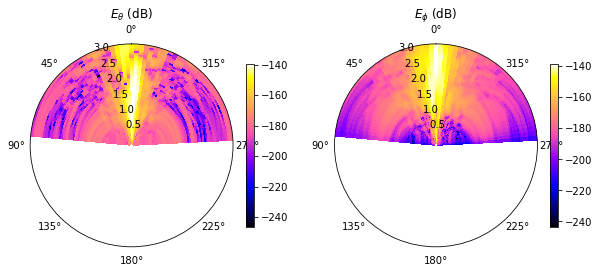

In [78]:
fig = figure(figsize=(10,10))
ax = subplot(1, 2, 1, projection='polar')
pcm = pcolormesh(theta,phi,20*np.log10(np.abs(Etheta)),cmap='gnuplot2')
colorbar(mappable = pcm,shrink = 0.3)
ax.set_title(r'$E_{\theta}$ (dB)')
ax.set_theta_offset(np.pi/2.0)
ax = subplot(1, 2, 2, projection='polar')
pcm = pcolormesh(theta,phi,20*np.log10(np.abs(Ephi)),cmap='gnuplot2')
colorbar(mappable = pcm,shrink = 0.3)
ax.set_title(r'$E_{\phi}$ (dB)')
ax.set_theta_offset(np.pi/2.0)

[[-1.52079633 -1.47079633 -1.42079633 ...  1.37920367  1.42920367
   1.47920367]
 [-1.52079633 -1.47079633 -1.42079633 ...  1.37920367  1.42920367
   1.47920367]
 [-1.52079633 -1.47079633 -1.42079633 ...  1.37920367  1.42920367
   1.47920367]
 ...
 [-1.52079633 -1.47079633 -1.42079633 ...  1.37920367  1.42920367
   1.47920367]
 [-1.52079633 -1.47079633 -1.42079633 ...  1.37920367  1.42920367
   1.47920367]
 [-1.52079633 -1.47079633 -1.42079633 ...  1.37920367  1.42920367
   1.47920367]]
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.1  0.1  0.1  ... 0.1  0.1  0.1 ]
 [0.15 0.15 0.15 ... 0.15 0.15 0.15]
 ...
 [2.95 2.95 2.95 ... 2.95 2.95 2.95]
 [3.   3.   3.   ... 3.   3.   3.  ]
 [3.05 3.05 3.05 ... 3.05 3.05 3.05]]


<ipython-input-79-594ecc200fe0>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = pcolormesh(phi,theta,20*np.log10(np.abs(Etheta)),cmap='gnuplot2')
<ipython-input-79-594ecc200fe0>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = pcolormesh(phi,theta,20*np.log10(np.abs(Ephi)),cmap='gnuplot2')


Text(0.5, 1.0, '$E_{\\phi}$ (dB)')

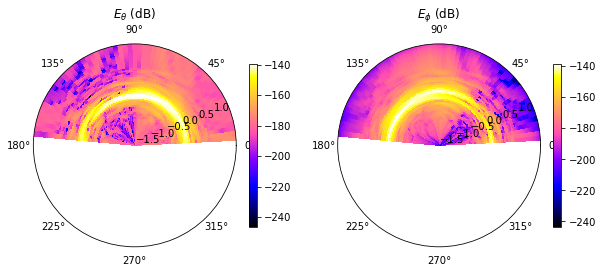

In [79]:
print(theta)
print(phi)
fig = figure(figsize=(10,10))
ax = subplot(1, 2, 1, projection='polar')
pcm = pcolormesh(phi,theta,20*np.log10(np.abs(Etheta)),cmap='gnuplot2')
colorbar(mappable = pcm,shrink = 0.3)
ax.set_title(r'$E_{\theta}$ (dB)')
ax = subplot(1, 2, 2, projection='polar')
pcm = pcolormesh(phi,theta,20*np.log10(np.abs(Ephi)),cmap='gnuplot2')
colorbar(mappable = pcm,shrink = 0.3)
ax.set_title(r'$E_{\phi}$ (dB)')

Text(0.5, 0.92, '$E_{\\phi}$ (dB)')

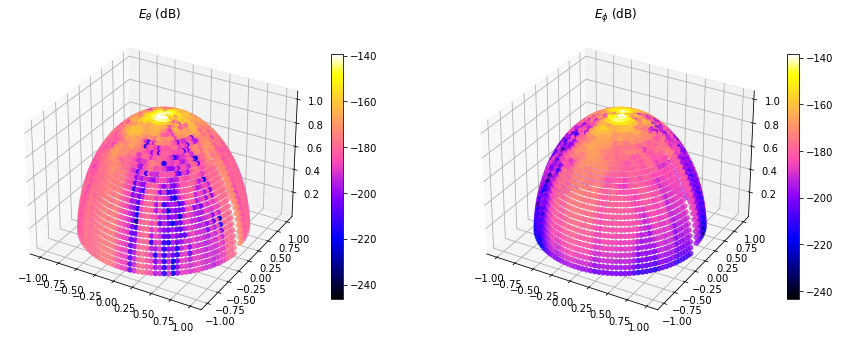

In [80]:
fig = figure(figsize=(15,15))
ax = subplot(1,2,1,projection='3d')

# Create the mesh in polar coordinates and compute corresponding Z.
R = Etheta
# Express the mesh in the cartesian system.
X = np.sin(theta)*np.cos(phi)
Y = np.sin(theta)*np.sin(phi)
Z = np.cos(theta)

# Plot the surface.
pcm = ax.scatter(X, Y, zs=Z,c=20*np.log10(Etheta),cmap='gnuplot2')
colorbar(mappable = pcm,shrink = 0.3)
ax.set_title(r'$E_{\theta}$ (dB)')

ax = subplot(1,2,2,projection='3d')

# Create the mesh in polar coordinates and compute corresponding Z.
R = Ephi
# Express the mesh in the cartesian system.
X = np.sin(theta)*np.cos(phi)
Y = np.sin(theta)*np.sin(phi)
Z = np.cos(theta)

# Plot the surface.
pcm = ax.scatter(X, Y, zs=Z,c=20*np.log10(Ephi),cmap='gnuplot2')
colorbar(mappable = pcm,shrink = 0.3)
ax.set_title(r'$E_{\phi}$ (dB)')

Text(0.5, 0.92, '$E_{\\phi}$ (dB)')

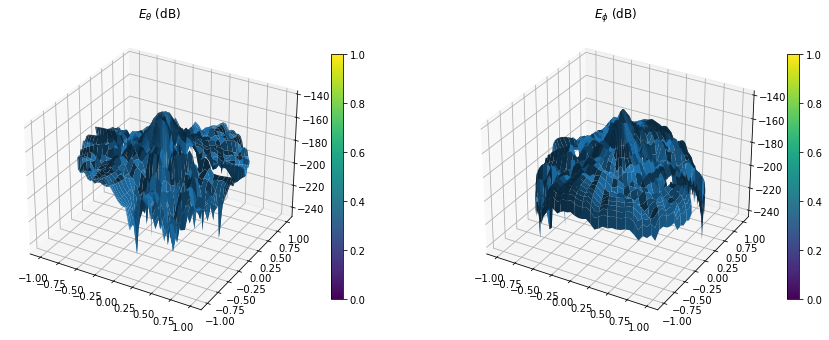

In [81]:
fig = figure(figsize=(15,15))
ax = subplot(1,2,1,projection='3d')

# Create the mesh in polar coordinates and compute corresponding Z.
R = Etheta
# Express the mesh in the cartesian system.
X = np.sin(theta)*np.cos(phi)
Y = np.sin(theta)*np.sin(phi)
Z = np.cos(theta)

# Plot the surface.
pcm = ax.plot_surface(X, Y,20*np.log10(Etheta))
colorbar(mappable = pcm,shrink = 0.3)
ax.set_title(r'$E_{\theta}$ (dB)')

ax = subplot(1,2,2,projection='3d')

# Create the mesh in polar coordinates and compute corresponding Z.
R = Ephi
# Express the mesh in the cartesian system.
X = np.sin(theta)*np.cos(phi)
Y = np.sin(theta)*np.sin(phi)
Z = np.cos(theta)

# Plot the surface.
pcm = ax.plot_surface(X, Y, 20*np.log10(Ephi))
colorbar(mappable = pcm,shrink = 0.3)
ax.set_title(r'$E_{\phi}$ (dB)')